In [1]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import kdephys as kde
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import acr
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots.mplstyle')

# ---------------------------- EXTRAS --------------------------------#
from acr.utils import swi_subs_exps, sub_probe_locations, sub_exp_types
import pingouin as pg
band_def = list(kde.utils.spectral.bands.keys())

/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# IMPORTANT PARAMETERS
# --------------------
REBOUND_LENGTH = '1h'
REL_STATE = 'NREM'

/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [7]:
def get_sd_reb_start(subject, exp):
    """Gets the SD start time and the rebound start time for a given subject and experiment."""
    
    # load some basic information, and the hypnogram
    h = acr.io.load_hypno_full_exp(subject, exp, update=False)
    rec_times = acr.info_pipeline.subject_info_section(subject, 'rec_times')

    # load some temporal information about the rebound, baseline, sd, etc. 
    stim_start, stim_end = acr.stim.stim_bookends(subject, exp)
    reb_start = h.hts(stim_end-pd.Timedelta('15min'), stim_end+pd.Timedelta('1h')).st('NREM').iloc[0].start_time
    if reb_start < stim_end:
        stim_end_hypno = h.loc[(h.start_time<stim_end)&(h.end_time>stim_end)] # if stim time is in the middle of a nrem bout, then it can be the start of the rebound
        if stim_end_hypno.state.values[0] == 'NREM':
            reb_start = stim_end
        else:
            raise ValueError('Rebound start time is before stim end time, need to inspect')

    assert reb_start >= stim_end, 'Rebound start time is before stim end time'

    bl_start_actual = rec_times[f'{exp}-bl']["start"]
    bl_day = bl_start_actual.split("T")[0]
    bl_start = pd.Timestamp(bl_day + "T09:00:00")

    if f'{exp}-sd' in rec_times.keys():
        sd_rec = f'{exp}-sd'
        sd_end = pd.Timestamp(rec_times[sd_rec]['end'])
    else:
        sd_rec = exp
        sd_end = stim_start
    sd_start_actual = pd.Timestamp(rec_times[sd_rec]['start'])
    sd_day = rec_times[sd_rec]['start'].split("T")[0]
    sd_start = pd.Timestamp(sd_day + "T09:00:00")
    return sd_start, reb_start

In [8]:
def relevant_stim_info(subject, exp):
    """Gets the stim start, stim_end, and pulse train times for a given subject and experiment."""
    store = 'Wavt' if 'swisin' in exp else 'Pu1_'
    if subject == 'ACR_26':
        store = 'Pu1_'
    if subject == 'ACR_28':
        store = 'Pu1_'
    stim_start, stim_end = acr.stim.stim_bookends(subject, exp)
    pon, poff = acr.stim.get_pulse_train_times(subject, exp, store, times=True)
    return stim_start, stim_end, pon, poff

In [3]:
sub_exp_combos = []
for subject in swi_subs_exps:
    for exp in swi_subs_exps[subject]:
        sub_exp_combos.append((subject, exp))


In [9]:
from pathlib import Path
import os
for subject, experiment in sub_exp_combos:
    print(subject, experiment)
    path = Path(f'./data/sd_data/{subject}--{experiment}--sd.parquet')
    if path.exists() == False:
        print(f'No file for {subject}--{experiment}--sd.parquet')
        continue
    df = pd.read_parquet(path)
    if 'stim_period' in df.columns:
        continue
    df['stim_period'] = 0
    df['pulse_train'] = 0
    sd_start, reb_start = get_sd_reb_start(subject, experiment)
    stim_start, stim_end, pon, poff = relevant_stim_info(subject, experiment)
    df.loc[(df['datetime']>stim_start) & (df['datetime']<stim_end), 'stim_period'] = 1
    for on, off in zip(pon, poff):
        df.loc[(df['datetime']>on) & (df['datetime']<off), 'pulse_train'] = 1
    df.to_parquet(path, version='2.6')

ACR_14 swi
ACR_16 swi2


In [20]:
sd_df = acr.io.read_full_df(folder='sd_data', method='polars')
#sd_df = sd_df.loc[sd_df.state == 'NREM']
#sd_df = sd_df.loc[sd_df['Band']=='delta']
#sd_df = sd_df.sort_values('subject')

In [84]:
good_wake = sd_df.filter(pl.col('pulse_train')==1).filter(pl.col('state')=='Wake-Good')
gen_wake = sd_df.filter(pl.col('pulse_train')==1).filter(pl.col('state')=='Wake')
gw_means = good_wake.groupby(['subject', 'exp', 'store', 'channel', 'Band', 'exp_type']).median()
gw_means = gw_means.to_pandas().reset_index()
w_means = gen_wake.groupby(['subject', 'exp', 'store', 'channel', 'Band', 'exp_type']).median()
w_means = w_means.to_pandas().reset_index()

# ACR Animals

In [85]:
acr_means = gw_means.exp_names().loc[gw_means['exp_type']=='acr'].loc[gw_means['Band']=='delta']
acr_means_deep = acr_means.loc[acr_means['channel'] >= 9]
acrm_corrected = acr_means.loc[acr_means['Bandpower']<=6.5]
acr_subs = acrm_corrected.groupby(['subject', 'exp', 'store'])['Bandpower'].median().to_frame().reset_index()

In [86]:
delta_reb_swi_nnxr = acr_subs.prb('NNXr').expmt('swi').sort_values('subject')['Bandpower'].to_numpy()
delta_reb_swi_nnxo = acr_subs.prb('NNXo').expmt('swi').sort_values('subject')['Bandpower'].to_numpy()

delta_reb_swisin_nnxr = acr_subs.prb('NNXr').expmt('swisin').sort_values('subject')['Bandpower'].to_numpy()
delta_reb_swisin_nnxo = acr_subs.prb('NNXo').expmt('swisin').sort_values('subject')['Bandpower'].to_numpy()

swi_stats = pg.ttest(delta_reb_swi_nnxr, delta_reb_swi_nnxo, paired=True)
swisin_stats = pg.ttest(delta_reb_swisin_nnxr, delta_reb_swisin_nnxo, paired=True)

swi_pval = round(swi_stats['p-val'][0], 5)
swisin_pval = round(swisin_stats['p-val'][0], 5)
print(f'swi p-value = {swi_pval}')
print(f'swisin p-value = {swisin_pval}')

swi p-value = 0.00046
swisin p-value = 0.12155


/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: divide by zero encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


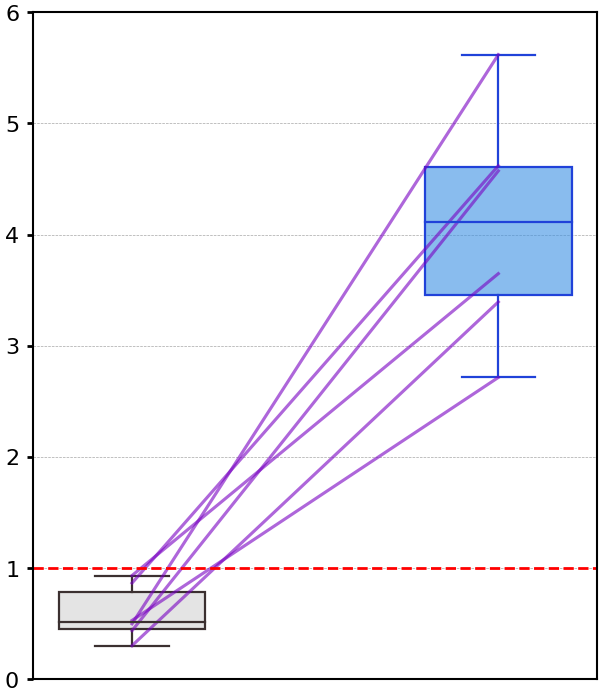

In [88]:
f, ax = plt.subplots(1, 1, figsize=(13, 15), sharey=True)

# OFF-INDUCTION
sns.boxplot(
            data=acr_subs.expmt('swi').prb('NNXr'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#3b3030", "linewidth": 3.2},
            whiskerprops={"color": "#3b3030", "linewidth": 3.2},
            capprops={"color": "#3b3030", "linewidth": 3.2},
            boxprops={"edgecolor": "#3b3030", "linewidth": 3.2},)

sns.boxplot(
            data=acr_subs.expmt('swi').prb('NNXo'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#2042d9", "linewidth": 3.2},
            whiskerprops={"color": "#2042d9", "linewidth": 3.2},
            capprops={"color": "#2042d9", "linewidth": 3.2},
            boxprops={"edgecolor": "#2042d9", "linewidth": 3.2},)

plt.tight_layout()
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))

#sns.swarmplot(data=acr_subs.expmt('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#202223', 'blue'], marker='o', size=15, ax=ax, alpha=0.4)
#sns.lineplot(data=acr_subs.expmt('swi').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#0175b9', ax=ax, linewidth=4.5, alpha=0.7)
sns.lineplot(data=acr_subs.expmt('swi').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#7800c2', ax=ax, linewidth=4.5, alpha=0.6)

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0, 6)
ax.axhline(1, color='red', linestyle='--', linewidth=4)
num_subs = len(acr_subs.expmt('swi').subject.unique())
#f.suptitle(f'SWA During 1-Hour NREM Rebound (Delta), ACR ANIMALS ONLY | (N={num_subs}) | p={swi_pval}', fontsize=12)

f.savefig('./plots/acr_induction_swi.png', dpi=300, bbox_inches='tight')

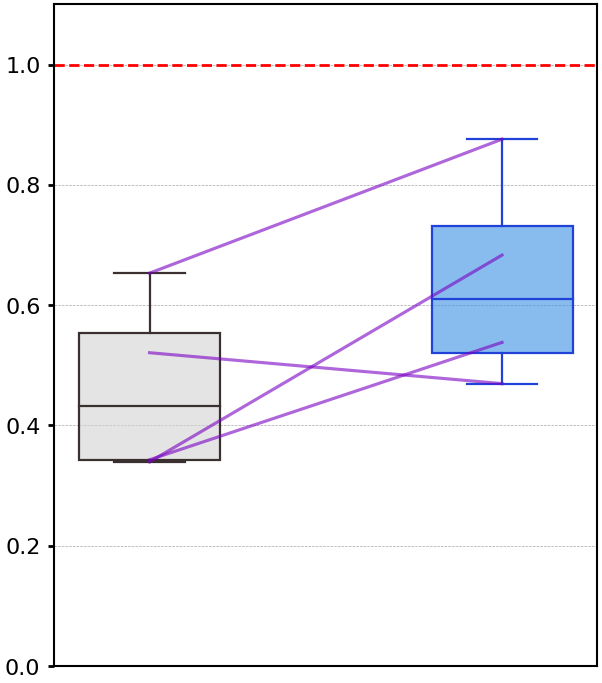

In [89]:
f, ax = plt.subplots(1, 1, figsize=(13, 15), sharey=True)

# OFF-INDUCTION
sns.boxplot(
            data=acr_subs.expmt('swisin').prb('NNXr'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#3b3030", "linewidth": 3.2},
            whiskerprops={"color": "#3b3030", "linewidth": 3.2},
            capprops={"color": "#3b3030", "linewidth": 3.2},
            boxprops={"edgecolor": "#3b3030", "linewidth": 3.2},)

sns.boxplot(
            data=acr_subs.expmt('swisin').prb('NNXo'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#2042d9", "linewidth": 3.2},
            whiskerprops={"color": "#2042d9", "linewidth": 3.2},
            capprops={"color": "#2042d9", "linewidth": 3.2},
            boxprops={"edgecolor": "#2042d9", "linewidth": 3.2},)

plt.tight_layout()
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))

#sns.swarmplot(data=acr_subs.expmt('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#202223', 'blue'], marker='o', size=15, ax=ax, alpha=0.4)
#sns.lineplot(data=acr_subs.expmt('swisin').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#0175b9', ax=ax, linewidth=4.5, alpha=0.7)
sns.lineplot(data=acr_subs.expmt('swisin').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#7800c2', ax=ax, linewidth=4.5, alpha=0.6)

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0, 1.1)
ax.axhline(1, color='red', linestyle='--', linewidth=4)
num_subs = len(acr_subs.expmt('swisin').subject.unique())
#f.suptitle(f'SWA During 1-Hour NREM Rebound (Delta), ACR ANIMALS ONLY | (N={num_subs}) | p={swisin_pval}', fontsize=12)

f.savefig('./plots/acr_induction_swisin.png', dpi=300, bbox_inches='tight')

# Martinotti Animals

In [90]:
som_means = gw_means.exp_names().loc[gw_means['exp_type']=='som'].loc[gw_means['Band']=='delta']
som_means_deep = som_means.loc[som_means['channel'] >= 9]
som_corrected = som_means.loc[som_means['Bandpower']<=6.5]
som_subs = som_corrected.groupby(['subject', 'exp', 'store'])['Bandpower'].median().to_frame().reset_index()

<Axes: xlabel='subject', ylabel='Bandpower'>

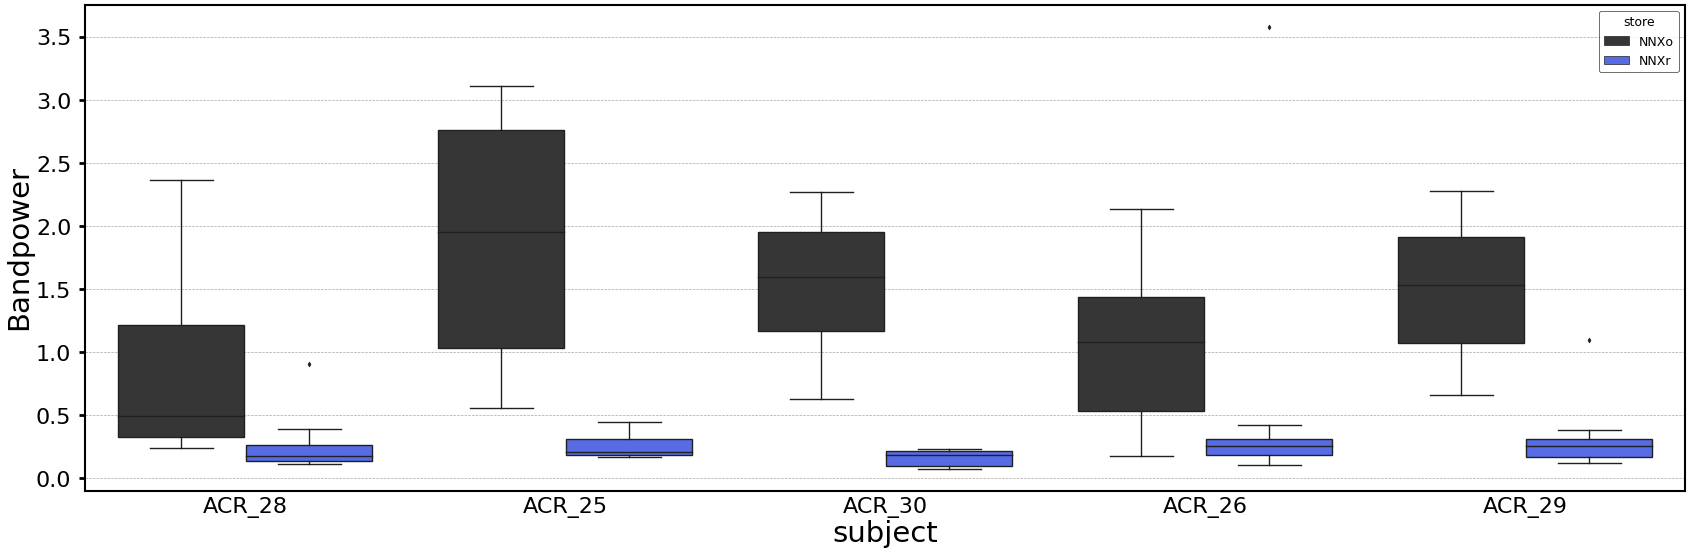

In [61]:
sns.boxplot(data=som_corrected, x='subject', y='Bandpower', hue='store')

In [91]:
delta_reb_swi_nnxr = som_subs.prb('NNXr').expmt('swi').sort_values('subject')['Bandpower'].to_numpy()
delta_reb_swi_nnxo = som_subs.prb('NNXo').expmt('swi').sort_values('subject')['Bandpower'].to_numpy()

delta_reb_swisin_nnxr = som_subs.prb('NNXr').expmt('swisin').sort_values('subject')['Bandpower'].to_numpy()
delta_reb_swisin_nnxo = som_subs.prb('NNXo').expmt('swisin').sort_values('subject')['Bandpower'].to_numpy()

swi_stats = pg.ttest(delta_reb_swi_nnxr, delta_reb_swi_nnxo, paired=True)
swisin_stats = pg.ttest(delta_reb_swisin_nnxr, delta_reb_swisin_nnxo, paired=True)

swi_pval = round(swi_stats['p-val'][0], 5)
swisin_pval = round(swisin_stats['p-val'][0], 5)
print(f'swi p-value = {swi_pval}')
print(f'swisin p-value = {swisin_pval}')

swi p-value = 0.00033
swisin p-value = 0.07877


/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: divide by zero encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


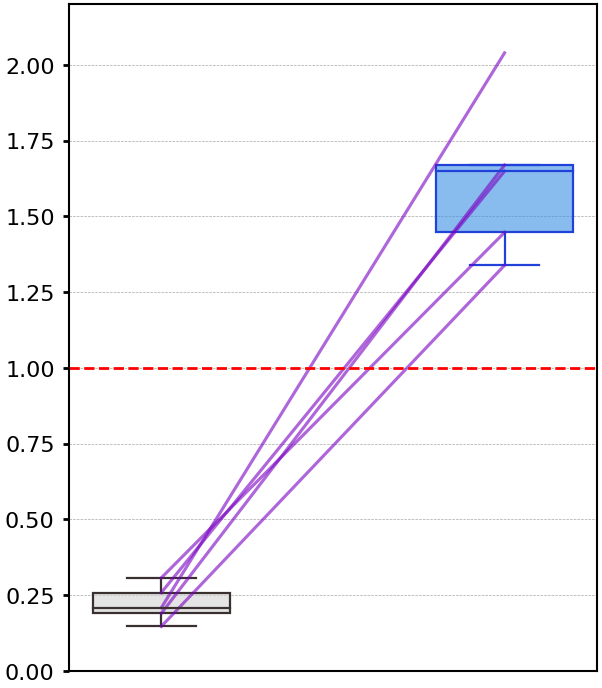

In [94]:
f, ax = plt.subplots(1, 1, figsize=(13, 15), sharey=True)

# OFF-INDUCTION
sns.boxplot(
            data=som_subs.expmt('swi').prb('NNXr'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#3b3030", "linewidth": 3.2},
            whiskerprops={"color": "#3b3030", "linewidth": 3.2},
            capprops={"color": "#3b3030", "linewidth": 3.2},
            boxprops={"edgecolor": "#3b3030", "linewidth": 3.2},)

sns.boxplot(
            data=som_subs.expmt('swi').prb('NNXo'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#2042d9", "linewidth": 3.2},
            whiskerprops={"color": "#2042d9", "linewidth": 3.2},
            capprops={"color": "#2042d9", "linewidth": 3.2},
            boxprops={"edgecolor": "#2042d9", "linewidth": 3.2},)

plt.tight_layout()
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))

#sns.swarmplot(data=som_subs.expmt('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#202223', 'blue'], marker='o', size=15, ax=ax, alpha=0.4)
#sns.lineplot(data=som_subs.expmt('swi').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#0175b9', ax=ax, linewidth=4.5, alpha=0.7)
sns.lineplot(data=som_subs.expmt('swi').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#7800c2', ax=ax, linewidth=4.5, alpha=0.6)

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0, 2.2)
ax.axhline(1, color='red', linestyle='--', linewidth=4)
num_subs = len(som_subs.expmt('swi').subject.unique())
#f.suptitle(f'SWA During 1-Hour NREM Rebound (Delta), ACR ANIMALS ONLY | (N={num_subs}) | p={swi_pval}', fontsize=12)

f.savefig('./plots/som_induction_swi.png', dpi=300, bbox_inches='tight')

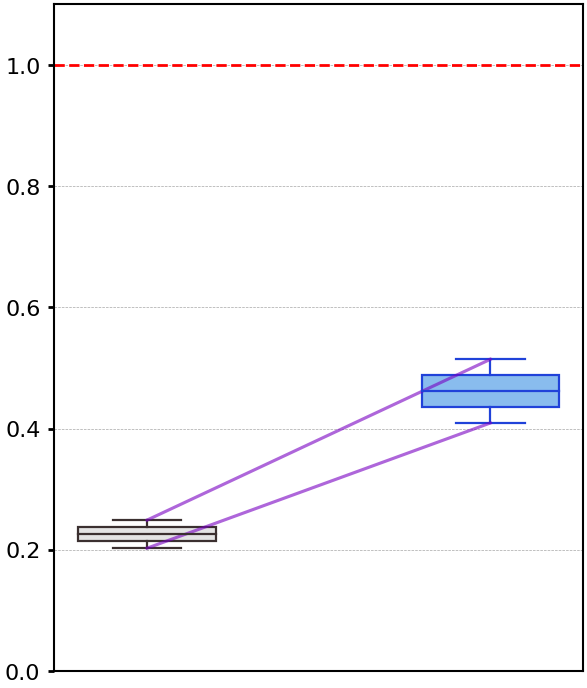

In [95]:
f, ax = plt.subplots(1, 1, figsize=(13, 15), sharey=True)

# OFF-INDUCTION
sns.boxplot(
            data=som_subs.expmt('swisin').prb('NNXr'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#3b3030", "linewidth": 3.2},
            whiskerprops={"color": "#3b3030", "linewidth": 3.2},
            capprops={"color": "#3b3030", "linewidth": 3.2},
            boxprops={"edgecolor": "#3b3030", "linewidth": 3.2},)

sns.boxplot(
            data=som_subs.expmt('swisin').prb('NNXo'), 
            x='store', y='Bandpower', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#2042d9", "linewidth": 3.2},
            whiskerprops={"color": "#2042d9", "linewidth": 3.2},
            capprops={"color": "#2042d9", "linewidth": 3.2},
            boxprops={"edgecolor": "#2042d9", "linewidth": 3.2},)

plt.tight_layout()
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))

#sns.swarmplot(data=som_subs.expmt('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#202223', 'blue'], marker='o', size=15, ax=ax, alpha=0.4)
#sns.lineplot(data=som_subs.expmt('swisin').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#0175b9', ax=ax, linewidth=4.5, alpha=0.7)
sns.lineplot(data=som_subs.expmt('swisin').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#7800c2', ax=ax, linewidth=4.5, alpha=0.6)

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0, 1.1)
ax.axhline(1, color='red', linestyle='--', linewidth=4)
num_subs = len(som_subs.expmt('swisin').subject.unique())
#f.suptitle(f'SWA During 1-Hour NREM Rebound (Delta), ACR ANIMALS ONLY | (N={num_subs}) | p={swisin_pval}', fontsize=12)

f.savefig('./plots/som_induction_swisin.png', dpi=300, bbox_inches='tight')